In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project'
FIGURES_PATH = f'{PROJECT_PATH}/figures/preprocessing'
def get_figure_path(name: str):
  return f'{FIGURES_PATH}/{name}.png'
DATASETS_PATH = f'{PROJECT_PATH}/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training.csv'
TESTING_PATH = f'{DATASETS_PATH}/test/test.csv'
INDEX_COL = 'pkSeqID'
COLUMNS_ORDERED = [
    'min', 'max', 'mean', 'stddev',
    'saddr', 'sport', 'daddr', 'dport',
    'srate', 'drate',
    'N_IN_Conn_P_SrcIP', 'N_IN_Conn_P_DstIP',
    'state_number', 'proto',
    'seq',
    'attack', 'category', 'subcategory'
]

In [57]:
training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]
training.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq,attack,category,subcategory
pkSeqID,,,,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984,1,DDoS,UDP
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724,1,DDoS,TCP
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921,1,DDoS,TCP
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168,1,DoS,UDP
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063,1,DDoS,UDP


In [58]:
testing = pd.read_csv(TESTING_PATH, index_col=INDEX_COL)[COLUMNS_ORDERED]

In [59]:
def process_categories(cat):
  if str(cat).lower().startswith('theft'):
    return 'Theft'
  if str(cat).lower().startswith('normal'):
    return 'Normal'
  if cat == 'DoS HTTP':
    return 'DoS TCP'
  if cat == 'DDoS HTTP':
    return 'DDoS TCP'
  return cat


In [60]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

cat_encoder_hot = OneHotEncoder()
cat_encoder_label = LabelEncoder()

In [61]:
X_train = training.drop(['attack' ,'category', 'subcategory'], axis=1)
y_train_cat = pd.DataFrame({'category': (training['category'] + ' ' + training['subcategory']).map(process_categories)})
y_train_hot = cat_encoder_hot.fit_transform(y_train_cat)
y_train_label = cat_encoder_label.fit_transform(y_train_cat['category'])

In [62]:
X_test = testing.drop(['attack', 'category', 'subcategory'], axis=1)
y_test_cat = pd.DataFrame({'category': (testing['category'] + ' ' + testing['subcategory']).map(process_categories)})
y_test_hot = cat_encoder_hot.transform(y_test_cat)
y_test_label = cat_encoder_label.transform(y_test_cat['category'])

In [63]:
X_train.head()

,min,max,mean,stddev,saddr,sport,daddr,dport,srate,drate,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,state_number,proto,seq
pkSeqID,,,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,192.168.100.150,6551,192.168.100.3,80,0.494549,0.0,100,100,4,udp,251984
2432264,3.856930,4.012924,3.934927,0.078003,192.168.100.150,5532,192.168.100.3,80,0.256493,0.0,38,100,3,tcp,256724
1976315,2.974100,3.609205,3.341429,0.268666,192.168.100.147,27165,192.168.100.3,80,0.294880,0.0,100,100,3,tcp,62921
1240757,0.000000,4.942302,3.222832,1.823185,192.168.100.150,48719,192.168.100.3,80,0.461435,0.0,63,63,4,udp,99168
3257991,2.979995,4.994452,3.983222,0.822418,192.168.100.147,22461,192.168.100.3,80,1.002999,0.0,100,100,4,udp,105063


In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, train_test_split

In [65]:
def process_port(p):
  return int(p, 16) if str(p).startswith('0x') else int(p)

def process_ports(ports: pd.DataFrame):
  return ports.map(process_port)


In [66]:
DEFAULT_RATE_SHIFT = 1.1

In [67]:
def shift_and_log(data, shift=DEFAULT_RATE_SHIFT): # 1.1 So that the output has no zero values, and a small change is not that significant
  return np.log10(data + shift)

In [68]:
from sklearn.base import BaseEstimator, TransformerMixin

srate_idx, drate_idx = [list(training.columns).index('srate'), list(training.columns).index('drate')]
class CombinedFeatureAdder(BaseEstimator, TransformerMixin):
  def __init__(self, normalize=True) -> None:
    super().__init__()
    self.normalize = normalize

  def fit(self, X, y=None):
    return self

  def transform(self, X: pd.DataFrame, y=None):
    srate_to_drate = np.log10(X.loc[:, 'srate'] + DEFAULT_RATE_SHIFT) / np.log10(X.loc[:, 'drate'] + DEFAULT_RATE_SHIFT)
    if self.normalize:
      return X.assign(srate_to_drate=np.log1p(srate_to_drate))
    else:
      return X.assign(srate_to_drate=srate_to_drate)

In [69]:
TO_DROP = ['saddr', 'daddr', 'seq']

data_cleaner = ColumnTransformer([
  ('drop', 'drop', TO_DROP),
  ('encode', OneHotEncoder(), ['proto']),
  ('port', FunctionTransformer(func=process_ports), ['sport', 'dport']),
  ('rate', FunctionTransformer(func=shift_and_log), ['srate', 'drate']),
], remainder='passthrough')

data_prep = Pipeline([
    ('augment', CombinedFeatureAdder()),
    ('clean', data_cleaner),
    ('std', StandardScaler()),
])

X_train_cleaned = data_prep.fit_transform(X_train)

In [70]:
X_train_cleaned.shape

(2934817, 17)

In [85]:
X_train_eval, _, y_train_eval_label, _, y_train_eval_hot, _, indices, _ = train_test_split(
    X_train_cleaned,
    y_train_label,
    y_train_hot,
    [i for i in range(len(y_train_label))],
    train_size=0.1,
    stratify=y_train_label,
    random_state=42
)

ValueError: Found input variables with inconsistent numbers of samples: [2934817, 2934817, 293481, 2934817]

In [73]:
def score_dbscan(eps, min_samples, X):
    print(f'Processing eps={eps}, min_samples={min_samples}...')
    model = DBSCAN(eps=eps, min_samples=min_samples)
    predictions = model.fit_predict(X)
    print('Model fitted.')
    out = {
        'eps': eps,
        'min_samples': min_samples,
        'davies': davies_bouldin_score(X_train_eval, predictions),
        'predictions': predictions,
        'classes': len(np.unique(predictions)),
        'outliers': sum(predictions == -1),
    }
    print('Done processing.')
    return out

In [74]:
from cuml.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

eps = [0.5, 1]
min_samples = [5, 50]

scores = []

for v1 in eps:
  for v2 in min_samples:
    scores.append(score_dbscan(v1, v2, X_train_eval))

pd.DataFrame(scores).drop('predictions', axis=1)

Processing eps=0.5, min_samples=5...
[2025-12-06 22:57:09.186] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=0.5, min_samples=50...
[2025-12-06 22:58:49.154] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=1, min_samples=5...
[2025-12-06 23:00:28.604] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=1, min_samples=50...
[2025-12-06 23:02:09.502] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.


,eps,min_samples,davies,classes,outliers
0,0.5,5,1.869980,271,1498
1,0.5,50,1.725337,64,12920
2,1.0,5,1.818899,68,443
3,1.0,50,1.673469,17,1794


In [28]:
for i in range(len(scores)):
  scores[i]['number of classes'] = len(np.unique(scores[i]['predictions']))
  scores[i]['amount of noise'] = sum(scores[i]['predictions'] == -1)

In [75]:
test_1_scores = scores
pd.DataFrame(test_1_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,0.5,5,1.869980,271,1498
1,0.5,50,1.725337,64,12920
2,1.0,5,1.818899,68,443
3,1.0,50,1.673469,17,1794


In [76]:
eps = [1, 5, 10, 20, 30, 50, 100]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))


Processing eps=1, min_samples=50...
[2025-12-06 23:03:50.090] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=5, min_samples=50...
[2025-12-06 23:05:30.568] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=10, min_samples=50...
[2025-12-06 23:07:35.205] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=20, min_samples=50...
[2025-12-06 23:09:58.363] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=30, min_sam

In [77]:
test_2_scores = scores
pd.DataFrame(test_2_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,1,50,1.673469,17,1794
1,5,50,1.938872,5,134
2,10,50,1.495496,3,46
3,20,50,0.897983,3,24
4,30,50,0.857636,2,23
5,50,50,0.857636,2,23
6,100,50,0.857636,2,23


In [78]:
eps = [i for i in range(21, 30)]
min_samples = 50
scores = []

for e in eps:
  scores.append(score_dbscan(e, min_samples, X_train_eval))

Processing eps=21, min_samples=50...
[2025-12-06 23:23:03.880] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=22, min_samples=50...
[2025-12-06 23:25:13.607] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=23, min_samples=50...
[2025-12-06 23:27:22.084] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=24, min_samples=50...
[2025-12-06 23:29:29.047] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=25, min_s

In [79]:
test_3_scores = scores
pd.DataFrame(test_3_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,21,50,0.895924,2,24
1,22,50,0.895924,2,24
2,23,50,0.895924,2,24
3,24,50,0.895924,2,24
4,25,50,0.895924,2,24
5,26,50,0.895924,2,24
6,27,50,0.857636,2,23
7,28,50,0.857636,2,23
8,29,50,0.857636,2,23


It seems the optimum epsilon value is 27

In [83]:
eps = 27
min_samples = [5, 10, 20, 50, 100, 200, 300]
scores = []

for m in min_samples:
  scores.append(score_dbscan(eps, m, X_train_eval))

Processing eps=27, min_samples=5...
[2025-12-06 23:53:14.189] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=10...
[2025-12-06 23:55:20.060] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=20...
[2025-12-06 23:57:25.711] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_samples=50...
[2025-12-06 23:59:31.400] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 8600 -> 7317. Using the larger integer type might result in better performance
Model fitted.
Done processing.
Processing eps=27, min_sa

In [84]:
test_4_scores = scores
pd.DataFrame(test_4_scores).drop('predictions', axis=1)

,eps,min_samples,davies,classes,outliers
0,27,5,0.033069,3,2
1,27,10,0.033069,3,2
2,27,20,0.033069,3,2
3,27,50,0.857636,2,23
4,27,100,0.857636,2,23
5,27,200,0.857636,2,23
6,27,300,0.895924,2,24


This clearly shows that lower values of min_samples improve the model significantly, need to try > 5

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.8)
reduced = pca.fit_transform(X_train_eval)

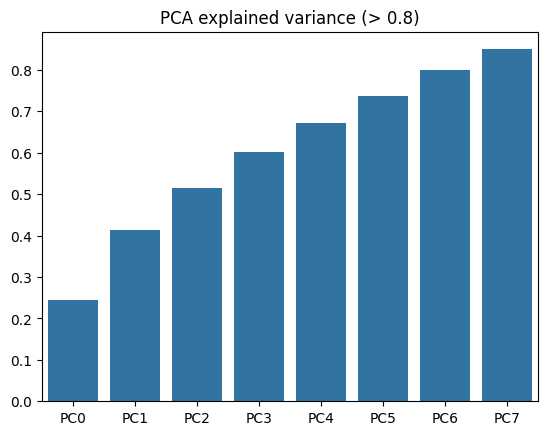

In [ ]:
sns.barplot(x=[f'PC{i}' for i in range(len(pca.components_))], y=np.cumsum(pca.explained_variance_ratio_))
title = 'PCA explained variance (> 0.8)'
plt.title(title)
plt.savefig(get_figure_path(title))

In [ ]:
pca_2 = PCA(n_components=2)
reduced_2_complete = pca_2.fit_transform(X_train_cleaned)
reduced_2 = pca_2.fit_transform(X_train_eval)

/tmp/ipython-input-24636211.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(get_figure_path(title))
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


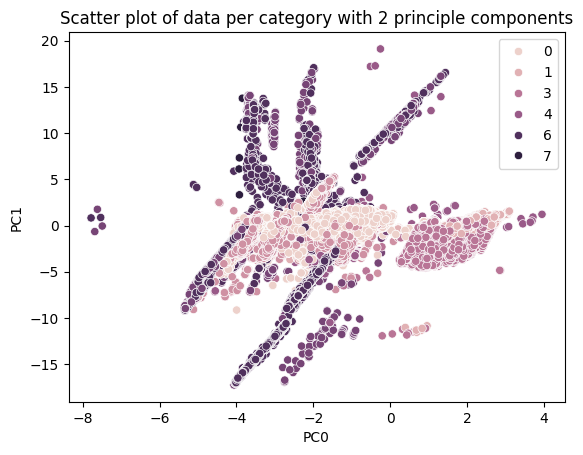

In [ ]:
sns.scatterplot(x=reduced_2_complete[:, 0], y=reduced_2_complete[:, 1], hue=y_train_label)
title = 'Scatter plot of data per category with 2 principle components'
plt.xlabel('PC0')
plt.ylabel('PC1')
plt.title(title)
plt.savefig(get_figure_path(title))

# TODO: Test with 8 features form PCA

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from cuml.ensemble import RandomForestClassifier
from cuml.linear_model import LogisticRegression
from cuml.neighbors import KNeighborsClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
}

no_pca_results = []
pca_results = []

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    y_target = y_train_eval_label

    X_no_pca = X_train_eval
    X_pca = reduced_2

    print(f'Processing model {model_name} no PCA...')
    cv_scores_no_pca = cross_val_score(model, X_no_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f'Processing model {model_name} with PCA...')
    cv_scores_pca = cross_val_score(model, X_pca, y_target, cv=cv, scoring='accuracy', n_jobs=-1)

    no_pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_no_pca),
        'cv_std': np.std(cv_scores_no_pca),
        'scores': cv_scores_no_pca
    })

    pca_results.append({
        'model': model_name,
        'cv_mean': np.mean(cv_scores_pca),
        'cv_std': np.std(cv_scores_pca),
        'scores': cv_scores_pca
    })
    print(f'Processing model done.')

no_pca_df = pd.DataFrame(no_pca_results)
pca_df = pd.DataFrame(pca_results)

Processing model Logistic Regression no PCA...
Processing model Logistic Regression with PCA...
Processing model done.
Processing model Random Forest no PCA...
Processing model Random Forest with PCA...
Processing model done.
Processing model KNN no PCA...
Processing model KNN with PCA...


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Processing model done.


In [ ]:
results_df = pd.DataFrame({
    'model': no_pca_df['model'],
    'no_pca_mean': no_pca_df['cv_mean'],
    'no_pca_std': no_pca_df['cv_std'],
    'pca_mean': pca_df['cv_mean'],
    'pca_std': pca_df['cv_std'],
    'difference': pca_df['cv_mean'] - no_pca_df['cv_mean']
})

print("\nComparison:")
results_df


Comparison:


,model,no_pca_mean,no_pca_std,pca_mean,pca_std,difference
0,Logistic Regression,0.933042,0.001021,0.684821,0.001374,-0.248221
1,Random Forest,0.992684,0.000449,0.567662,0.001262,-0.425022
2,KNN,0.994460,0.000177,0.952900,0.000987,-0.041560
